### Model for count data

Based on Ch.1.4. from [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/).

In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS, HMC
import torch as T

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

pyro.enable_validation()

In [2]:
filename = 'txtdata.csv'

! wget -qN https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/{filename}

obs_data = T.from_numpy(np.loadtxt(filename)).to(T.float32)
print(f"{obs_data.shape = }")
print(f"{obs_data.dtype = }")

! rm {filename}

SSL_INIT
obs_data.shape = torch.Size([74])
obs_data.dtype = torch.float32


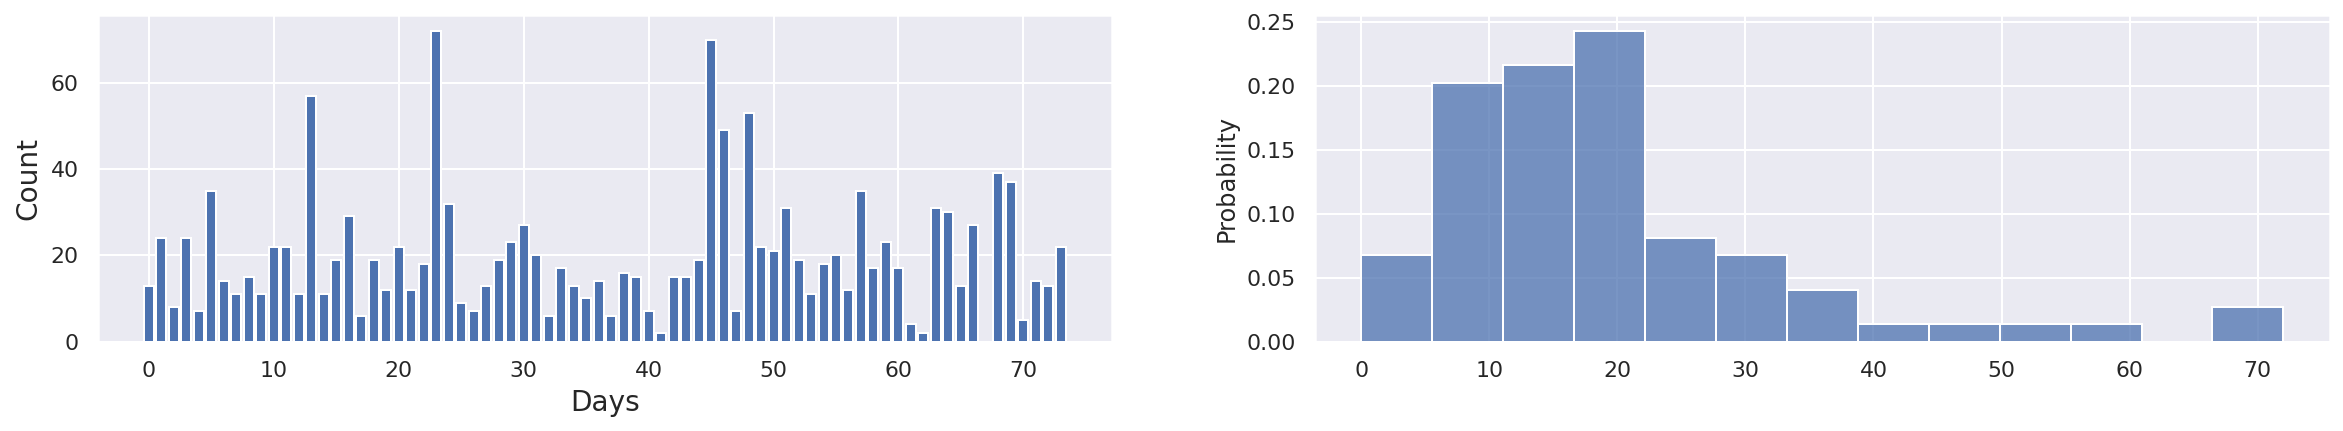

In [3]:
plt.figure(figsize=(20, 3))

plt.subplot(1, 2, 1)
plt.bar(np.arange(len(obs_data)), obs_data)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.subplot(1, 2, 2)
sns.histplot(obs_data, stat='probability')
pass

The question is:

**Did the user’s texting habits change over time?**

We start by modelling the count for each day as a random variable $C_t \sim \mathsf{Poisson}(\lambda)$.

We further hypothesize that the rate $\lambda$ increases somewhere in the second half of the data. Thus, we can introduce a _switchpoint_ $\tau$:

$$
\lambda = \left\{
    \begin{array}{ll}
    \lambda_1, & t < \tau \\
    \lambda_2, & t \geq \tau
    \end{array}
\right.
$$

If there's no change at all, then we would expect $\lambda_1 = \lambda_2$ (and $\tau$ can be virtually any point between $t=\overline{1 \dots T}$).

Next, we need to choose the priors over $\lambda_1, \lambda_2, \tau$:
$$
\begin{array}{ll}
\lambda_1 &\sim \mathsf{Exp}(\alpha) \\
\lambda_2 &\sim \mathsf{Exp}(\alpha) \\
\tau &\sim \mathsf{DiscreteUniform}(1, T)
\end{array}
$$
A good initial guess for the hyperparameter $\alpha$ is $\dfrac{1}{\frac{1}{T}\sum_{t=1}^T C_t}$, since the inverse of the mean of the observed data is $\mathbb{E}[\lambda\mid\alpha] = \dfrac1\alpha$

### Define model

In [4]:
def model(obs_data):
    n = obs_data.shape[0]
    alpha = 1 / obs_data.mean()
    
    lam1 = pyro.sample("lam1", dist.Exponential(alpha))
    lam2 = pyro.sample("lam2", dist.Exponential(alpha))
    
    tau = 1 + (n * pyro.sample("tau", dist.Uniform(0, 1))).long()
    lam = T.cat([
        lam1.expand(tau),
        lam2.expand(n - tau)
    ])
    
    # find posterior of λ such that these samples matched the observed ones
    # i.e. what values of λ are more likely to produce the observed data?
    with pyro.plate("data", len(obs_data)) as idx:
        obs = pyro.sample("obs", dist.Poisson(lam), obs=obs_data)

### Perform inference

In [5]:
pyro.clear_param_store()

kernel = NUTS(
    model, jit_compile=True, ignore_jit_warnings=True, max_tree_depth=3
)
posterior = MCMC(
    kernel, num_samples=10_000, warmup_steps=1_000
)
posterior.run(obs_data) # argument is passed to model

Sample: 100%|█████████████████████████████████████| 11000/11000 [01:27, 126.33it/s, step size=1.43e-01, acc. prob=0.830]                                                                                                                      


### Plot posteriors

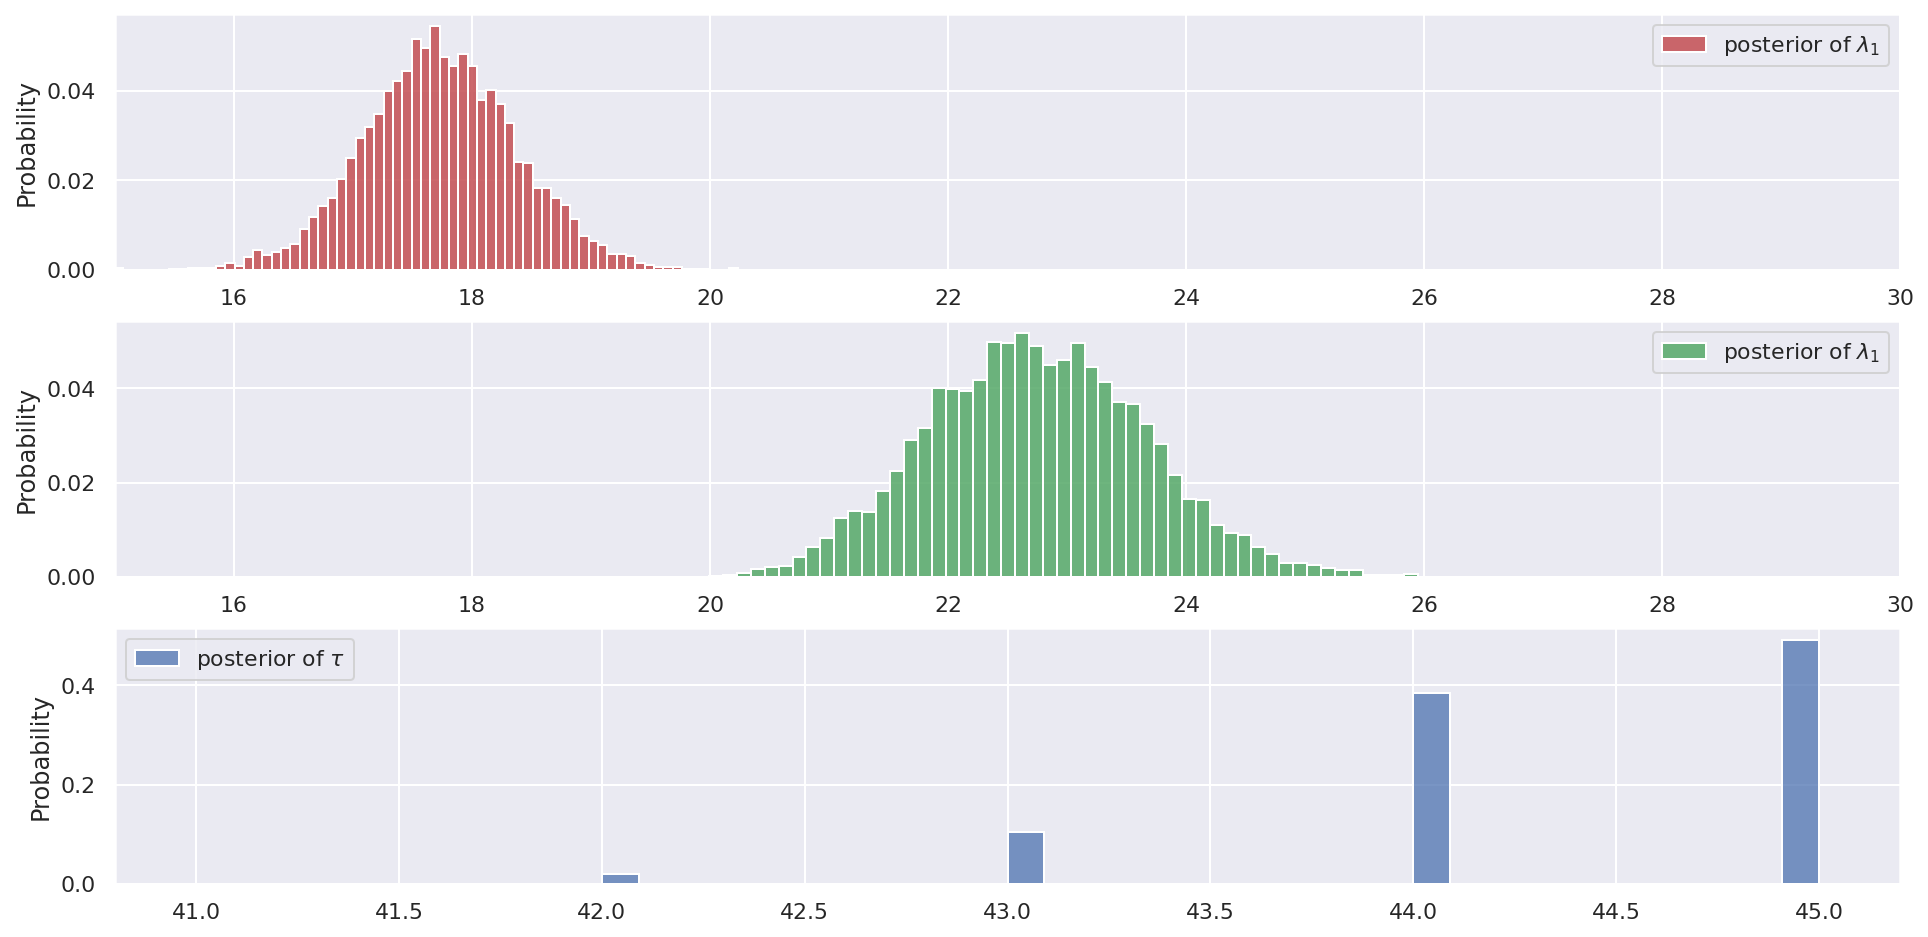

In [6]:
trace = posterior.get_samples()
lam1_samples = trace['lam1']
lam2_samples = trace['lam2']
tau_samples = (1 + len(obs_data) * trace['tau']).long()

plt.figure(figsize=(16, 8))

plt.subplot(3, 1, 1)
sns.histplot(lam1_samples, alpha=0.85, label="posterior of $\lambda_1$", color='r', stat='probability')
plt.xlim([15, 30])
plt.legend()

plt.subplot(3, 1, 2)
sns.histplot(lam2_samples, alpha=0.85, label="posterior of $\lambda_1$", color='g', stat='probability')
plt.xlim([15, 30])
plt.legend()

plt.subplot(3, 1, 3)
sns.histplot(tau_samples, stat='probability', label=r"posterior of $\tau$")
plt.legend()

pass

In [7]:
for τ in range(40, 51):
    mean_before = obs_data[:τ].mean()
    mean_after = obs_data[τ:].mean()

    print(f"({τ=}) {mean_before=:6.3f} -> {mean_after=:6.3f} (Δ={mean_after - mean_before:6.3f})")

(τ=40) mean_before=18.525 -> mean_after=21.176 (Δ= 2.651)
(τ=41) mean_before=18.244 -> mean_after=21.606 (Δ= 3.362)
(τ=42) mean_before=17.857 -> mean_after=22.219 (Δ= 4.362)
(τ=43) mean_before=17.791 -> mean_after=22.452 (Δ= 4.661)
(τ=44) mean_before=17.727 -> mean_after=22.700 (Δ= 4.973)
(τ=45) mean_before=17.756 -> mean_after=22.828 (Δ= 5.072)
(τ=46) mean_before=18.891 -> mean_after=21.143 (Δ= 2.252)
(τ=47) mean_before=19.532 -> mean_after=20.111 (Δ= 0.579)
(τ=48) mean_before=19.271 -> mean_after=20.615 (Δ= 1.345)
(τ=49) mean_before=19.959 -> mean_after=19.320 (Δ=-0.639)
(τ=50) mean_before=20.000 -> mean_after=19.208 (Δ=-0.792)
